In [10]:
# import
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer, PorterStemmer
import seaborn as sns

# For random forest
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# For MLP
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

import joblib
# For parallel processing
import multiprocessing
from joblib import Parallel, delayed
from tqdm import tqdm

In [11]:
df = pd.read_csv('WELFake_Dataset.csv')

# for testing with 500 rows
# df = pd.read_csv('WELFake_Dataset.csv', nrows=500)

df.head()
df.shape

(72134, 4)

In [12]:
# Download NLTK
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('stopwords')
#nltk.download('wordnet')

# Preprocessing

In [13]:
df.isna().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [14]:
df = df.dropna()
df = df.drop(columns=['Unnamed: 0'])
df.isna().sum()

title    0
text     0
label    0
dtype: int64

In [15]:
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1


In [16]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()


In [17]:
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words
    tokens = [word for word in tokens if word.lower() not in stop_words]
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # POS tagging
    tagged_tokens = pos_tag(stemmed_tokens)
    # Lemmatize
    lemmatized_tokens = []
    for word, tag in tagged_tokens:
        if tag.startswith('N'):
            lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='n'))
        elif tag.startswith('V'):
            lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='v'))
        elif tag.startswith('R'):
            lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='r'))
        elif tag.startswith('J'):
            lemmatized_tokens.append(lemmatizer.lemmatize(word, pos='a'))
        else:
            lemmatized_tokens.append(word)

    # Extract words and their POS tags
    return " ".join([f"{word}/{tag}" for word, tag in tagged_tokens])

In [18]:
# Pre-processing (parallel and chunking)
num_cores = multiprocessing.cpu_count()

def parallel_preprocess(text_series):
    return text_series.apply(preprocess_text)

tqdm.pandas()

# Chunk size. sesuain sama hardware. 200 makan kurang lebih 4 GB RAM. semakin besar semakin berat.
chunk_size = 200
# Process dataframe in chunks (so python don't eat your 12 gigs of RAM and brick your machine XDXD)
print("Pre-processing title column...")
for chunk_start in tqdm(range(0, len(df), chunk_size)):
    chunk_end = min(chunk_start + chunk_size, len(df))
    chunk = df['title'].iloc[chunk_start:chunk_end]
    processed_chunk = Parallel(n_jobs=num_cores)(delayed(preprocess_text)(text) for text in chunk)
    df.loc[chunk.index, 'preprocessed_title'] = processed_chunk
print("Pre-processing title column complete.")

print("Pre-processing text column...")
for chunk_start in tqdm(range(0, len(df), chunk_size)):
    chunk_end = min(chunk_start + chunk_size, len(df))
    chunk = df['text'].iloc[chunk_start:chunk_end]
    processed_chunk = Parallel(n_jobs=num_cores)(delayed(preprocess_text)(text) for text in chunk)
    df.loc[chunk.index, 'preprocessed_text'] = processed_chunk
print("Pre-processing text column complete.")

print("Saving pre-processed data as CSV...")
df.to_csv('dataset_preprocessed.csv', index=False)
print("Saving complete.")

Pre-processing title column...


100%|██████████| 358/358 [00:35<00:00,  9.99it/s]


Pre-processing title column complete.
Pre-processing text column...


100%|██████████| 358/358 [04:24<00:00,  1.35it/s]


Pre-processing text column complete.
Saving pre-processed data as CSV...
Saving complete.


In [19]:
# Pre-processing (single)
#tqdm.pandas()
#df['processed_text'] = df['text'].progress_apply(preprocess_text)

In [20]:
df.head()

,title,text,label,preprocessed_title,preprocessed_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,law/NN enforc/RB high/JJ alert/NN follow/VBP t...,comment/NN expect/VBP barack/NN obama/JJ membe...
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,unbeliev/JJ !/. obama/NN ’/NNP attorney/NN gen...,",/, demonstr/VBZ gather/NN last/JJ night/NN ex..."
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"bobbi/NN jindal/NN ,/, rais/NN hindu/NN ,/, us...",dozen/NN polit/NN activ/NN pastor/NN came/VBD ...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,satan/JJ 2/CD :/: russia/NN unv/JJ imag/NN ter...,"rs-28/JJ sarmat/NN missil/NN ,/, dub/JJ satan/..."
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,time/NN !/. christian/JJ group/NN sue/NN amazo...,say/VB one/CD time/NN someon/NN su/NN southern...


In [21]:
df['combined'] = df['preprocessed_text'] + " " + df['preprocessed_title']
x_train, x_test, y_train, y_test = train_test_split(df['combined'], df['label'], test_size=0.2, random_state=42)
df['combined'].head()

0    comment/NN expect/VBP barack/NN obama/JJ membe...
2    ,/, demonstr/VBZ gather/NN last/JJ night/NN ex...
3    dozen/NN polit/NN activ/NN pastor/NN came/VBD ...
4    rs-28/JJ sarmat/NN missil/NN ,/, dub/JJ satan/...
5    say/VB one/CD time/NN someon/NN su/NN southern...
Name: combined, dtype: object

In [22]:
#TF IDF
vectorizer = TfidfVectorizer(max_df=0.7)
tfidf_train = vectorizer.fit_transform(x_train)
tfidf_test = vectorizer.transform(x_test)


# RandomForest Model

In [23]:
rf_model = RandomForestClassifier(n_jobs = -1, verbose = 2)
rf_model.fit(tfidf_train, y_train)

y_pred = rf_model.predict(tfidf_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 19 of 100

building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


Random Forest Model
Accuracy: 0.9470925356443948
              precision    recall  f1-score   support

           0     0.9529    0.9396    0.9462      7081
           1     0.9416    0.9545    0.9480      7227

    accuracy                         0.9471     14308
   macro avg     0.9472    0.9470    0.9471     14308
weighted avg     0.9472    0.9471    0.9471     14308



<Axes: >

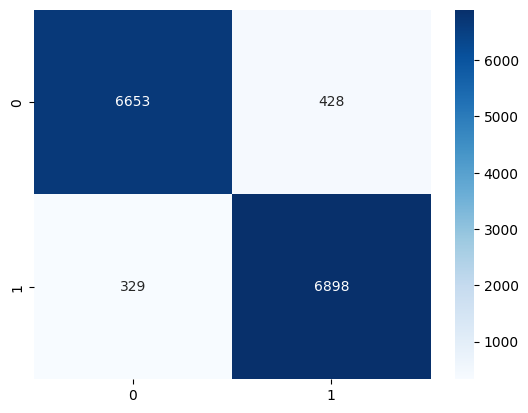

In [28]:
# Evaluate
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Model")
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')

In [29]:
joblib.dump(rf_model, 'random_forest_model.pkl')


['random_forest_model.pkl']

In [30]:
# GPU Check
from tensorflow.python.client import device_lib
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

2.16.1
Num GPUs Available:  0
['/device:CPU:0']


# MLP

In [31]:
# Reset the variable (just in case)
x_train, x_test, y_train, y_test = train_test_split(df['combined'], df['label'], test_size=0.2, random_state=42)

# TF-IDF
vectorizer = TfidfVectorizer(max_df=0.7)
tfidf_train = vectorizer.fit_transform(x_train)
tfidf_test = vectorizer.transform(x_test)

In [32]:
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

input_shape = tfidf_train.shape[1]

In [37]:
model = Sequential()

# Input layer
model.add(Input(shape=(input_shape,)))

# Dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(tfidf_train, y_train, epochs=10, batch_size=128, validation_data=(tfidf_test, y_test))

# Evaluate the model

loss, accuracy = model.evaluate(tfidf_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 148s 328ms/step - accuracy: 0.8826 - loss: 0.2839 - val_accuracy: 0.9700 - val_loss: 0.0802
Epoch 2/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.9919 - loss: 0.0291 - val_accuracy: 0.9720 - val_loss: 0.0874
Epoch 3/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.9965 - loss: 0.0106 - val_accuracy: 0.9720 - val_loss: 0.1007
Epoch 4/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 145s 323ms/step - accuracy: 0.9982 - loss: 0.0061 - val_accuracy: 0.9697 - val_loss: 0.1562
Epoch 5/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.9987 - loss: 0.0033 - val_accuracy: 0.9702 - val_loss: 0.1534
Epoch 6/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9719 - val_loss: 0.1575
Epoch 7/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 143s 320ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.9695 - val_loss: 0.1564
Epoch 8/10
448/448 ━━━━━━━━━━━━━━━━━━━━ 144s 321ms/step - accuracy: 0.9987 -

In [ ]:
rf_model = RandomForestClassifier(n_jobs = -1, verbose = 2)
rf_model.fit(tfidf_train, y_train)

y_pred = rf_model.predict(tfidf_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 100building tree 2 of 100
building tree 3 of 100

building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100building tree 19 of 100

building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   30.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.4s finished


In [ ]:
joblib.dump(model, 'MLP_model.pkl')


['MLP_model.pkl']